# Milestones 2

Nama: Wilona Natalie Elvaretta  
Batch: RMT-028  
Dataset: `product-shipment.csv`  
Deployment: [Link](https://huggingface.co/spaces/wilonatalie/p1-ftds028-rmt-m2)

**Problem**:  
Di jaman digital seperti sekarang ini, semakin banyak orang  yang berbelanja online. Kemudahan, kecepatan dan akses yang ditawarkan memang berbeda dengan berbelanja secara konvensional. Contohnya, pembeli tidak harus mengeluarkan tenaga atau usaha untuk mengunjungi toko tertentu, dan mereka bisa menunggu kiriman belanja datang ke rumah.

Keunikan berbelanja online datang dengan aspek-aspek baru yang harus diperhatikan, dan salah satu yang paling penting adalah ketepatan waktu sampainya pesanan. Hal ini menjadi krusial karena berbeda dengan belanja konvensional, pembeli harus menunggu untuk bisa memakai atau menggunakan barang tersebut. Objektif program ini adalah untuk membangun strategi yang bisa memperbaiki isu keterlambatan pesanan.

Oleh karena itu, program ini ingin memprediksi apakah barang akan sampai tepat waktu atau tidak berdasarkan beberapa data dari database pembeli sebuah perusahaan yang bergerak di usaha elektronik. Model untuk memprediksi akan dipilih dari 5 jenis algoritma klasifikasi: 
- K-Nearest Neighbors (KNN)
- Support Vector Machine (SVM)
- Decision Tree
- Random Forest
- Ada Boosting  

Pemilihan model terbaik dilakukan dengan cross-validation, dan dioptimalkan menggunakan hyperparameter tuning. Metric yang digunakan adalah recall, karena kita ingin fokus meminimalisir False Negative, yaitu barang yang tidak sampai tepat waktu tetapi diprediksi sampai tepat waktu.
Program ini diharapkan selesai tanggal 7 Maret 2024.


## Import Libraries

In [1]:
# General
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import time

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
import phik

# Model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV, GridSearchCV

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Saving
import pickle


## Data Loading

Dataset di-load dari Kaggle, di [link](https://www.kaggle.com/datasets/prachi13/customer-analytics) berikut.

In [2]:
# Load data
df_ori = pd.read_csv('product_shipment.csv')
df = df_ori.copy()

Ingin ditampilkan preview 5 data teratas dan terbawah.

In [3]:
# Top 5 data
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [4]:
# Bottom 5 data
df.tail()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
10994,10995,A,Ship,4,1,252,5,medium,F,1,1538,1
10995,10996,B,Ship,4,1,232,5,medium,F,6,1247,0
10996,10997,C,Ship,5,4,242,5,low,F,4,1155,0
10997,10998,F,Ship,5,2,223,6,medium,M,2,1210,0
10998,10999,D,Ship,2,5,155,5,low,F,6,1639,0


In [5]:
# Data information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB


Informasi dari data di atas dan `schema.png`:
- Dataset terdiri dari 10999 observasi dengan 12 atribut
- Tidak ada missing values
- Terdapat 7 data kategorikal:
    - Ordinal: `Customer_rating`, `Product_importance`
    - Nominal: `ID`, `Warehouse_block`, `Mode_of_Shipment`, `Gender`, `Reached.on.Time_Y.N`
    - _Data kategorikal `Customer_rating` `Reached.on.Time_Y.N` sudah dinyatakan dalam angka/encoded_
- Data lainnya termasuk numerik: `Customer_care_calls`, `Prior_purcahases`, `Product_importance`, `Discount_offered`, `Weight_in_gms`


Nama kolom akan disederhanakan dengan karakter lowercase saja.

In [6]:
# Rename columns
df.rename(columns = {
    'ID':'id', 
    'Warehouse_block':'warehouse_block', 
    'Mode_of_Shipment':'shipment_mode', 
    'Customer_care_calls':'cust_care_calls', 
    'Customer_rating':'cust_rating', 
    'Cost_of_the_Product':'product_cost', 
    'Prior_purchases':'purchase_prior', 
    'Product_importance':'product_importance', 
    'Gender':'gender', 
    'Discount_offered':'discount', 
    'Weight_in_gms':'weight', 
    'Reached.on.Time_Y.N':'delay', 
}, inplace = True)

df.columns

Index(['id', 'warehouse_block', 'shipment_mode', 'cust_care_calls',
       'cust_rating', 'product_cost', 'purchase_prior', 'product_importance',
       'gender', 'discount', 'weight', 'delay'],
      dtype='object')

Tidak lupa cek data duplikat dan menghapusnya jika ada.

In [7]:
# Duplicated data
df.duplicated().sum()

0

## Exploratory Data Analysis (EDA)

Eksplorasi data akan dilakukan terhadap variabel numerik, kategorikal, dan melalui visualisasi.

In [8]:
# Separate numerical  & categorical columns
num_col = ['cust_care_calls', 'product_cost', 'purchase_prior', 'discount', 'weight']
cat_nom_col = ['warehouse_block', 'shipment_mode', 'gender', 'delay']
cat_ord_col = ['cust_rating', 'product_importance']
cat_col = cat_nom_col + cat_ord_col

### Numerical variables

Ingin dilihat sejumlah statistik untuk mendapatkan insight awal dari data.

In [9]:
# Describing data
df[num_col].describe()

,cust_care_calls,product_cost,purchase_prior,discount,weight
count,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,4.054459,210.196836,3.567597,13.373216,3634.016729
std,1.141490,48.063272,1.522860,16.205527,1635.377251
min,2.000000,96.000000,2.000000,1.000000,1001.000000
25%,3.000000,169.000000,3.000000,4.000000,1839.500000
50%,4.000000,214.000000,3.000000,7.000000,4149.000000
75%,5.000000,251.000000,4.000000,10.000000,5050.000000
max,7.000000,310.000000,10.000000,65.000000,7846.000000


Insights:
- Rata-rata `cust_care_calls` sebanyak 4 kali. Bisa dibilang frekuensinya cukup sering. Namun perlu diingat bahwa customer care umumnya menerima telepon terkait apapun, seperti pertanyaan mengenai produk, keluhan untuk proses transaksi, menanyakan status pengiriman, issue saat menggunakan produk, dll
- Rentang `product_cost` di 96 USD sampai 310 USD,  tidak lebar mengingat beragamnya jenis produk dan harga barang elektronik. Harga juga terpatok lumayan tinggi, mungkin perusahaan hanya menjual line produk tertentu 
- Dari `purchase_prior`, pembeli rata-rata kembali lagi untuk melakukan pembelian berikutnya. Baik untuk perusahaan punya langganan
- `discount` menunjukkan perusahaan menjaga pricing produknya cukup ketat, dengan memberikan diskon harga yang sangat sedikit (sebagian besar di bawah 10%)
- Produk paling berat yang dijual sekitar 8 kg dari informasi `weight`. Barang eletronik seberat ini biasanya berkaitan dengan perabotan rumah tangga

### Categorical variables

Sebelum eksplor lebih jauh, tipe data variabel kategorikal disesuaikan terlebih dahulu.

In [10]:
# Change data type
for cat in cat_nom_col:
    df[cat] = pd.Categorical(df[cat], ordered = False)

df['cust_rating'] = pd.Categorical(df['cust_rating'], ordered = True)
df['product_importance'] = pd.Categorical(df['product_importance'], ordered = True, categories = ['low', 'medium', 'high'])

df.dtypes

id                       int64
warehouse_block       category
shipment_mode         category
cust_care_calls          int64
cust_rating           category
product_cost             int64
purchase_prior           int64
product_importance    category
gender                category
discount                 int64
weight                   int64
delay                 category
dtype: object

Di bawah ini ditampilkan semua unique values (dan pengurutannya jika ia ordinal) serta beberapa statistik mengenai variabel kategorikal.

In [11]:
# Display data type
for cat in cat_col:
    print(f'Variabel {cat}')
    print(f'Banyak unique values: {len(df[cat].unique())}')
    print(f'Unique values: {df[cat].unique()}\n')

Variabel warehouse_block
Banyak unique values: 5
Unique values: ['D', 'F', 'A', 'B', 'C']
Categories (5, object): ['A', 'B', 'C', 'D', 'F']

Variabel shipment_mode
Banyak unique values: 3
Unique values: ['Flight', 'Ship', 'Road']
Categories (3, object): ['Flight', 'Road', 'Ship']

Variabel gender
Banyak unique values: 2
Unique values: ['F', 'M']
Categories (2, object): ['F', 'M']

Variabel delay
Banyak unique values: 2
Unique values: [1, 0]
Categories (2, int64): [0, 1]

Variabel cust_rating
Banyak unique values: 5
Unique values: [2, 5, 3, 1, 4]
Categories (5, int64): [1 < 2 < 3 < 4 < 5]

Variabel product_importance
Banyak unique values: 3
Unique values: ['low', 'medium', 'high']
Categories (3, object): ['low' < 'medium' < 'high']



In [12]:
# Describe data
df[cat_col].describe()

,warehouse_block,shipment_mode,gender,delay,cust_rating,product_importance
count,10999,10999,10999,10999,10999,10999
unique,5,3,2,2,5,3
top,F,Ship,F,1,3,low
freq,3666,7462,5545,6563,2239,5297


Insight:
- Ada 5 `warehouse_block` di dataset, dan pengiriman terbanyak dilakukan dari blok F
- Pengiriman paling sering dilakukan dengan `shipment_mode` Ship, atau dengan kapal. Dapat diinterpretasikan bahwa perusahaan banyak mengirim barang ke luar kota, atau barang yang dikirimkan biasanya besar atau mungkin dalam bulk sehingga lebih efektif mobilisasi dengan kapal
- Pembelian dilakukan oleh 2 `gender` dan banyak transaksinya cukup seimbang
- Data `delay` menunjukkan lebih banyak pesanan pelanggan yang sampai terlambat, dibandingkan tepat waktu. Bukan performa dan citra yang baik untuk perusahaan, dan dicari tahu faktor apakah yang menyebabkan keterlambatan ini
- `cust_rating` yang diterima perusahaan paling banyak 3, menggambarkan kepuasan yang kurang baik namun ini diberikan dari ~20% data. Akan diperiksa lebih lanjut terkait rating
- Hampir setengah dari produk yang dijual memiliki `product_importance` rendah. Karena tidak ada informasi mengenai bagaimana produk dikategorikan, ini bisa dieksplor lebih lanjut

### Visualizations

#### 1. Rating & delayed deliveries

Melihat pada EDA bahwa perusahaan paling banyak menerima rating 3.0, ingin dilihat lebih lanjut bagaimana porsinya dalam data. Ternyata, pemberian rating oleh pelanggan sangat merata, hampir sama semua persentasenya.

Rating seperti ini tidak baik untuk perusahaan, karena selalu diinginkan pembeli yang puas dan bisa menilai experiencenya berbelanja serta produk yang dibeli dengan memuaskan. Setidaknya mayoritas pembeli harus bisa menilai 4.0 untuk experience belanja serta produk yang didapatkan, dan meminimalkan rating < 4.0. Jika ini berlangsung terus menerus, hampir pasti akan terjadi penurunan sales karena di masa sekarang, rating sebuah toko cukup menentukan apakah customer akan berbelanja di sana atau tidak (belajar dari pengalaman orang lain).

Lebih jauh, tidak ada perbedaan signifikan antara pemberian rating untuk pesanan on-time dengan delayed. Maka, dapat disimpulkan delayed deliveries tidak memengaruhi bagaimana customer memberikan rating.

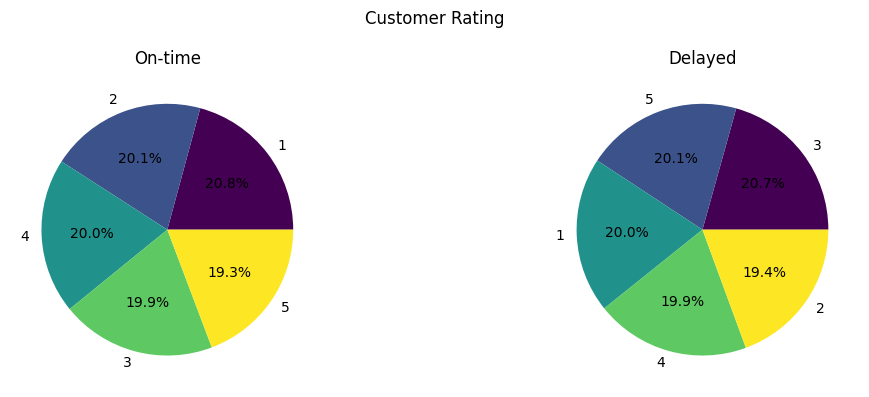

In [13]:
# Pie chart
plt.figure(figsize = (12, 4))

plt.subplot(1,2,1)
df[df['delay'] == 0]['cust_rating'].value_counts().plot(kind = 'pie', colormap = 'viridis', autopct = '%1.1f%%')
plt.title('On-time')
plt.ylabel('')

plt.subplot(1,2,2)
df[df['delay'] == 1]['cust_rating'].value_counts().plot(kind = 'pie', colormap = 'viridis', autopct = '%1.1f%%')
plt.title('Delayed')
plt.ylabel('')

plt.suptitle('Customer Rating')
plt.tight_layout()
plt.show()

#### 2. Discounts

Ada banyak cara diskon diberikan. Dua di antaranya adalah diskon langsung ke harga produk, dan diskon yang diberikan sebagai reward pada pelanggan. 

Pertama, di bawah sebelah kiri adalah line plot antara harga produk dan rata-rata diskon untuk produk dengan harga yang sama. Terlihat ada penurunan diskon seiring naiknya harga produk. Hal lainnya yang ditunjukkan adalah barang yang lebih murah cenderung lebih bervariasi diskonnya. Dua hal ini wajar terjadi, karena penjual ingin menjaga agar harga produk (terutama yang di kelas tinggi, karena mungkin tidak banyak stoknya) tidak jatuh, atau bisa dibilang untuk menjaga harga pasaran.

Kedua, plot sebelah kanan menunjukkan bagaimana dampak frekuensi pembelian terhadap diskon. Tidak ada perbedaan yang signifikan untuk rata-rata diskon yang diterima, namun ada pola yang menarik di mana mereka yang 2-3 kali berbelanja dan yang berbelanja 7 kali atau lebih, mendapat diskon lebih besar dari lainnya. Ada program berpola seperti ini, di mana penjual berusaha unutk attract pelanggan untuk join membership dengan cara memberikan diskons sebelumnya. Mungkin penjual menawarkan membership setelah melihat potensi customer menjadi pelanggan tetap. Sedangkan untuk mereka yang sudah jadi pelanggan tetap, semakin sering berbelanja bisa mengumpulkan poin atau entitled untuk memperoleh diskon yang lebih besar.

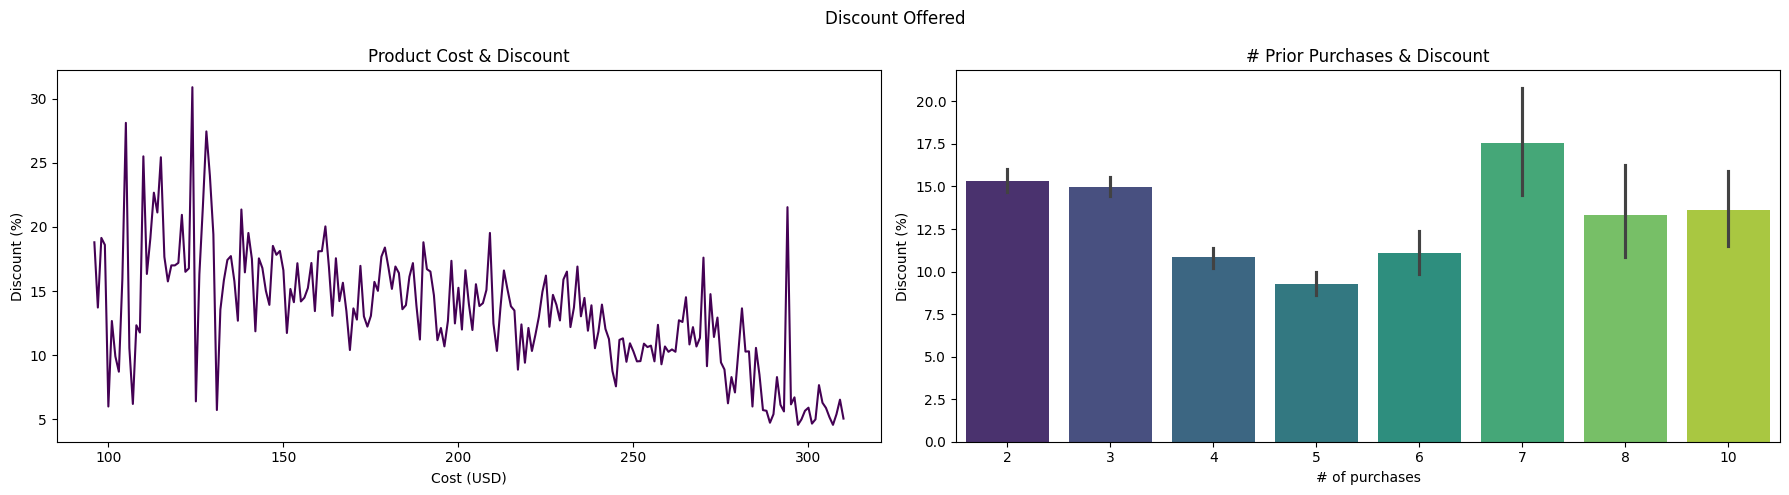

In [14]:
# Lineplot & barplot
plt.figure(figsize = (18, 5))

plt.subplot(1,2,1)
df.groupby('product_cost')['discount'].mean().plot(kind = 'line', colormap = 'viridis')
plt.title('Product Cost & Discount')
plt.xlabel('Cost (USD)')
plt.ylabel('Discount (%)')

plt.subplot(1,2,2)
sns.barplot(data = df, x = 'purchase_prior', y = 'discount', palette = 'viridis')
plt.title('# Prior Purchases & Discount')
plt.ylabel('Discount (%)')
plt.xlabel('# of purchases')

plt.suptitle('Discount Offered')
plt.tight_layout()
plt.show()

Selanjutnya, plot di bawah ini menunjukkan transaksi untuk setiap tingkat diskon, dibedakan dengan apakah pesanan sampai terlambat atau tepat waktu.

Untuk produk yang diskon < 20%, terlihat lebih banyak pengantaran tepat waktu dibandingkan dari yang delay. Yang menarik adalah saat diskon > 20%, di mana semua pengantaran behind schedule. Fenomena ini ditemui juga sehari-hari, di mana ada tanggal-tanggal tertentu atau "tanggal cantik" saat banyak penjual memberikan diskon yang lebih besar secara bersamaan, dan akibatnya adalah lonjakan pesanan di berbagai platform e-commerce. Ini berimbas pada sistem pengantaran pesanan-pesanan tersebut, di mana jauh lebih banyak pesanan yang harus diantarkan dengan jumlah kurir kurang lebih sama di hari-hari lainnya. Oleh karena itu, jasa pengantaran seringkali kewalahan menghadapi order membludak dan konsekuensinya adalah pesanan terlambat sampai di rumah konsumen.

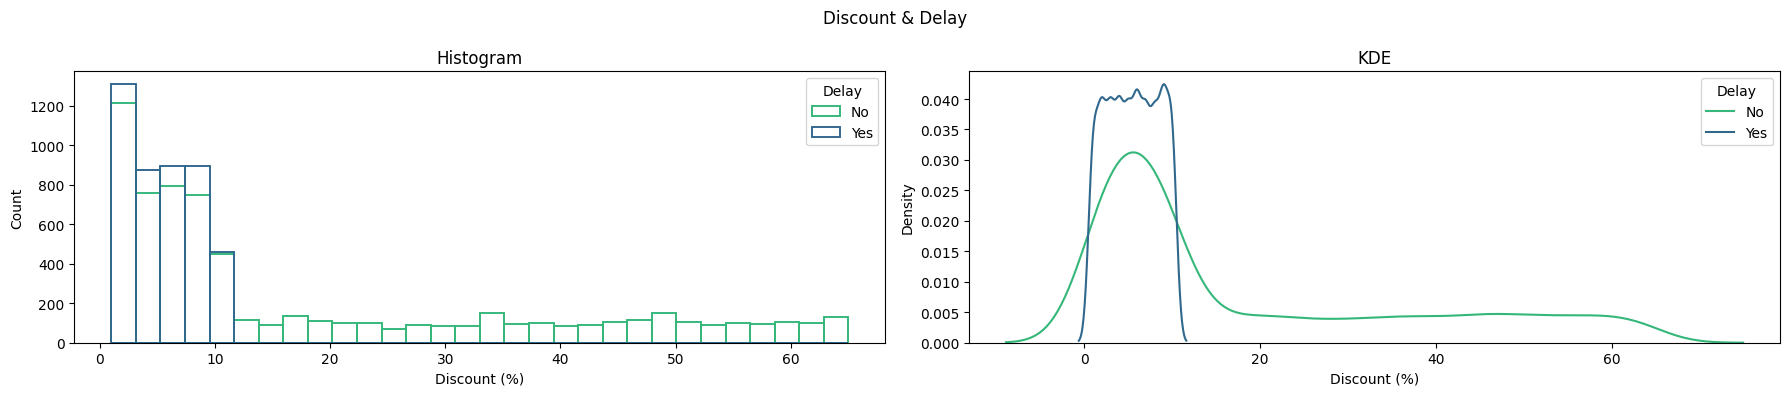

In [15]:
# Histplot
plt.figure(figsize = (18, 4))

plt.subplot(1,2,1)
sns.histplot(data = df, x = 'discount', bins = 30, hue = 'delay', palette = 'viridis', fill = False)
plt.title('Histogram')
plt.xlabel('Discount (%)')
plt.legend(title = 'Delay', labels = ['No', 'Yes'])

plt.subplot(1,2,2)
sns.kdeplot(data = df, x = 'discount', hue = 'delay', palette = 'viridis',)
plt.title('KDE')
plt.xlabel('Discount (%)')
plt.legend(title = 'Delay', labels = ['No', 'Yes'])

plt.suptitle('Discount & Delay')
plt.tight_layout()
plt.show()

#### 3. Product costs & customer call

Dari EDA sebelumnya, didapati rata-rata pelanggan menghubungi customer care sebanyak 4 kali. Ingin dilihat bagaimana frekuensi telepon dipengaruhi oleh harga produk, dan apakah ada pola yang berbeda untuk barang yang terlambat dan yang tepat waktu.

Jelas terlihat ada tren naik, di mana semakin tinggi harga produk, semakin sering juga pelanggan menghubungi customer care. Ada beberapa kemungkinan untuk ini terjadi:
- Jika membeli produk dengan harga tinggi, customer lebih waswas atau kuatir akan proses pembeliannya, dari pembayaran ke barang sampai di rumah dengan baik-baik saja
- Produk lebih mahal lebih sulit untuk dipahami penggunaannya, atau menuntut maintenance yang lebih rumit dan rutin
- Customer ingin mendapatkan informasi karena biaya yang dikeluarkan tidak kecil, seperti informasi produk atau layanan after-sales yang diperoleh

Menarik melihat bahwa hampir tidak ada perbedaan untuk garis transaksi on-time dan delay, yang berarti kecil kemungkinan customer call yang dilakukan adalah terkait delayed deliveries.

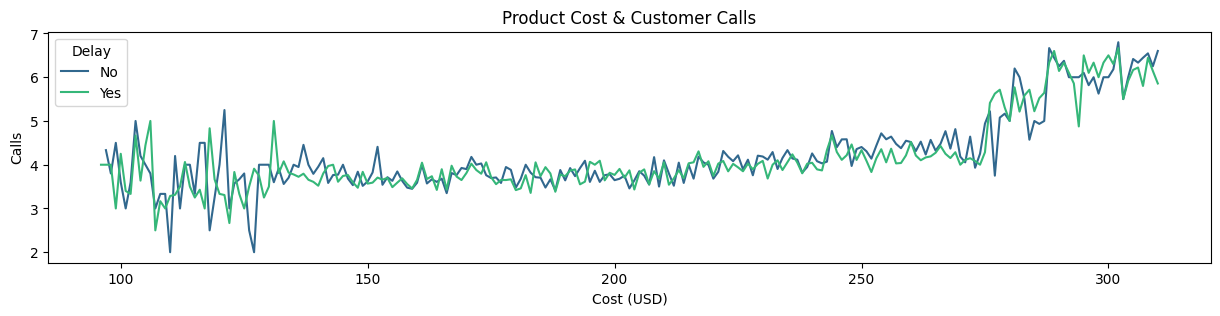

In [16]:
# Lineplot
plt.figure(figsize = (15, 3))
sns.lineplot(data = df, x = 'product_cost', y = 'cust_care_calls', ci = None, hue = 'delay', palette = 'viridis')
plt.title('Product Cost & Customer Calls')
plt.xlabel('Cost (USD)')
plt.ylabel('Calls')
plt.legend(title = 'Delay', labels = ['No', 'Yes'])
plt.show()


#### 4. Product importance

Perusahaan mengkategorikan produknya berdasarkan importance: low, medium, high. Tidak diketahui dasar dari pengkategorian ini, namun ingin dianalisa apakah produk yang high importance lebih diprioritaskan untuk sampai tepat waktu.

Dari pie chart di bawah, ternyata itu tidak terjadi. Malahan persentase produk dengan predikat high importance lebih besar porsinya pada pie chart Delay, dibandingkan dengan pada pie chart On-time. Dapat disimpulkan bahwa customer yang memesan barang dengan tingkat importance lebih tinggi, tidak mendapat privilege berupa kepastian memperoleh pesanannya tepat waktu.

Bisa digali kembali ke perusahaan, apa yang dimaksud dengan tingkat importance produk.

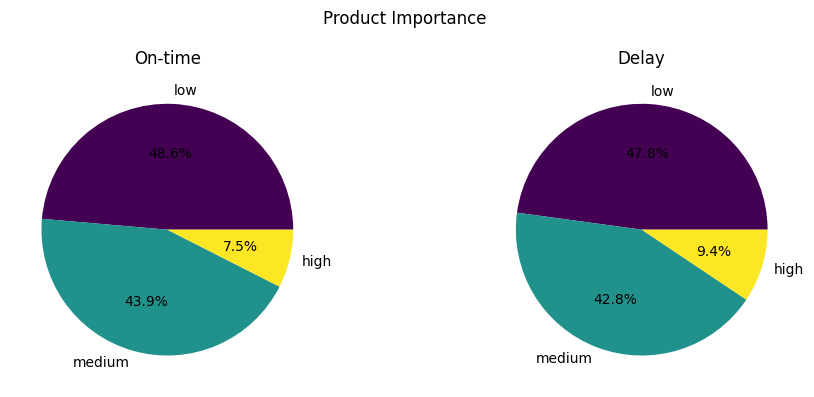

In [17]:
# Pie chart
plt.figure(figsize = (10, 4))

plt.subplot(1,2,1)
df[df['delay'] == 0]['product_importance'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', colormap = 'viridis')
plt.title('On-time')
plt.ylabel('')

plt.subplot(1,2,2)
df[df['delay'] == 1]['product_importance'].value_counts().plot(kind = 'pie', autopct='%1.1f%%', colormap = 'viridis')
plt.title('Delay')
plt.ylabel('')

plt.suptitle('Product Importance')
plt.tight_layout()
plt.show()

#### 5. Product weight, shipment & warehouse

Ada 3 faktor lain yang memengaruhi seberapa cepat pesanan sampai ke tujuan: berat produk, di mana produk disimpan, dan moda transportasi pengantaran. Ketiga hal ini berkaitan juga satu sama lain.

Produk yang berat membutuhkan usaha khusus untuk memindahkannya, dan terlihat bahwa pengantaran menggunakan moda transportasi Ship punya rentang berat produk yang lebih lebar. Dengan kata lain, produk yang berat diantar oleh Ship, dan yang ringan kebanyakan diantar dengan pesawat atau Flight. Masuk akal karena biaya transportasi dengan pesawat cukup mahal dengan kapasitas ruang yang tidak semasif kapal. Terlihat juga bahwa untuk pesanan tepat waktu, berat produknya kurang lebih sama untuk setiap moda transportasi. Namun ini berbeda ketika melihat delayed deliveries, di mana produk cenderung lebih berat.

Di plot sebelah kanan, terlihat bahwa rata-rata berat produk yang disimpan di masing-masing warehouse kurang lebih sama, sehingga keterlambatan produk yang berat dapat disimpulkan disebabkan oleh moda pengantarannya, dan bukan dari lokasi warehouse.

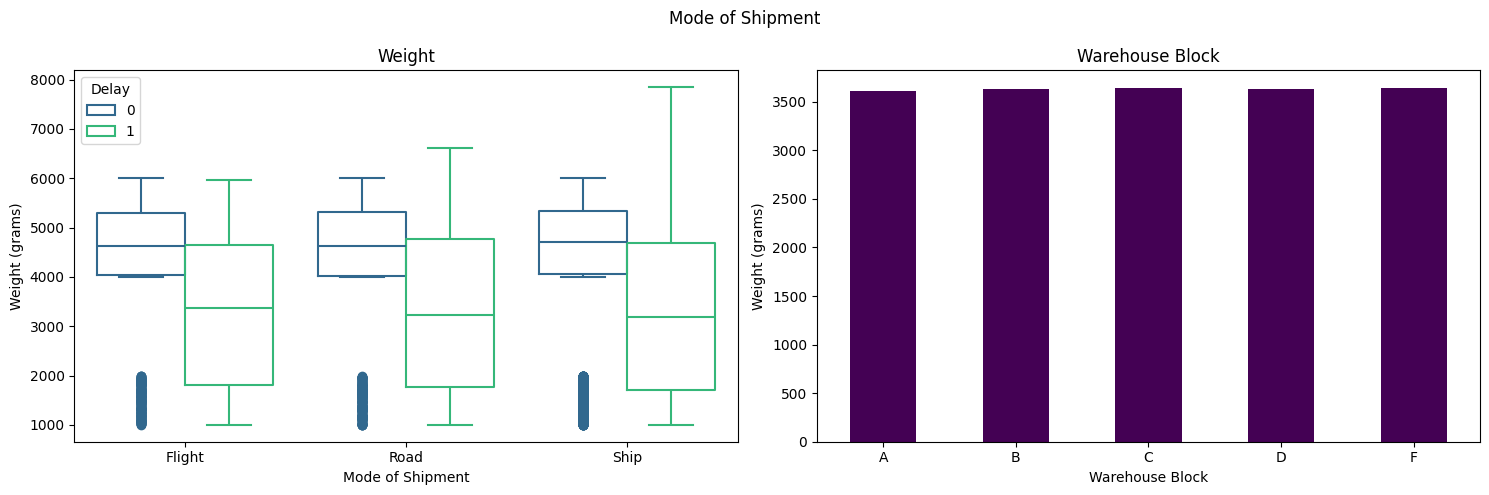

In [18]:
# Boxplot
plt.figure(figsize = (15, 5))

plt.subplot(1,2,1)
sns.boxplot(data = df, x = 'shipment_mode', y = 'weight', hue = 'delay', palette = 'viridis', fill = False, legend = 'brief',  ax = plt.subplot(1,2,1))
plt.title('Weight')
plt.ylabel('Weight (grams)')
plt.xlabel('Mode of Shipment')
plt.legend(title = 'Delay')

df.groupby('warehouse_block')['weight'].mean().plot(kind = 'bar', colormap = 'viridis', ax = plt.subplot(1,2,2))
plt.title('Warehouse Block')
plt.ylabel('Weight (grams)')
plt.xlabel('Warehouse Block')
plt.xticks(rotation = 0)

plt.suptitle('Mode of Shipment')
plt.tight_layout()
plt.show()

Lebih lanjut, di bawah ini bisa dilihat bahwa pesanan paling banyak diantar dari Warehouse Block F. Namun mengonfirmasi dugaan di atas, porsi delivery yang on-time dan delayed kurang lebih sama di masing-masing warehouse, sehingga lokasi warehouse bukan alasan mengapa pesanan terlambat sampai.

Ditunjukkan juga moda shipment untuk setiap warehouse, yang porsinya kurang lebih sama di mana paling banyak shipment dilakukan dengan Ship. Melihat pengantaran dengan Ship biasanya untuk produk lebih berat dan ini terjadi di semua warehouse, menjadi masuk akal bagaimana setiap warehouse punya persentase keterlambatan pengantaran pesanan dari total pesanan masing-masing per warehouse|.

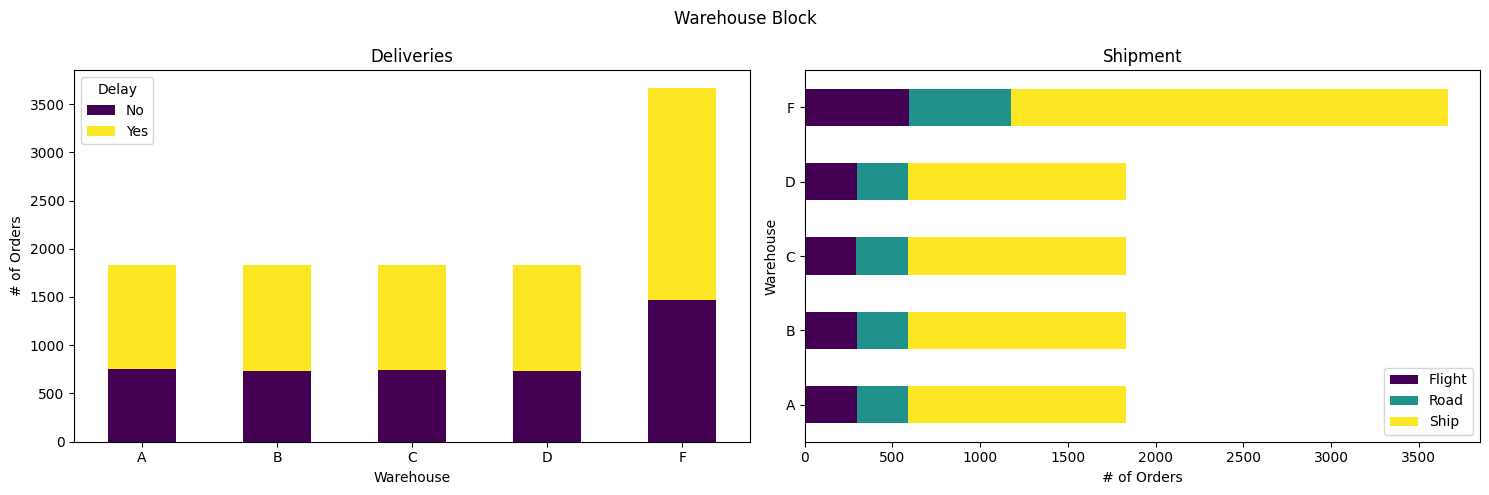

In [19]:
# Barplot
plt.figure(figsize = (15, 5))

df.groupby('warehouse_block')['delay'].value_counts().unstack().plot(kind = 'bar', colormap = 'viridis', stacked = True, ax = plt.subplot(1,2,1))
plt.title('Deliveries')
plt.ylabel('# of Orders')
plt.xlabel('Warehouse')
plt.xticks(rotation = 0)
plt.legend(title = 'Delay', labels = ['No', 'Yes'])

df.groupby('warehouse_block')['shipment_mode'].value_counts().unstack().plot(kind = 'barh', colormap = 'viridis', stacked = True, ax = plt.subplot(1,2,2))
plt.title('Shipment')
plt.ylabel('Warehouse')
plt.xlabel('# of Orders')
plt.xticks(rotation = 0)
plt.legend()

plt.suptitle('Warehouse Block')
plt.tight_layout()
plt.show()

## Feature Engineering (FE)

### Data splitting

Data akan di-split sebelum memulai pre-processing, menjadi: data inference, data train, dan data test.

In [20]:
# Split inference data
df_inf = df.sample(n = 1, random_state = 1)

# Delete inference from dataset
df.drop(df_inf.index, inplace = True)

# Reset data index
df.reset_index(drop = True, inplace = True)
df_inf.reset_index(drop = True, inplace = True)

# Saving inference to csv
df_inf.to_csv('inference.csv', index = False)

In [21]:
# Split feature & target
X = df.drop(['delay'], axis = 1)
y = df[['delay']]

X.head()

,id,warehouse_block,shipment_mode,cust_care_calls,cust_rating,product_cost,purchase_prior,product_importance,gender,discount,weight
0,1,D,Flight,4,2,177,3,low,F,44,1233
1,2,F,Flight,4,5,216,2,low,M,59,3088
2,3,A,Flight,2,2,183,4,low,M,48,3374
3,4,B,Flight,3,3,176,4,medium,M,10,1177
4,5,C,Flight,2,2,184,3,medium,F,46,2484


In [22]:
# Split data train & test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

# Each data shape
print('Data Shape')
print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

Data Shape
X train: (8798, 11)
y train: (8798, 1)
X test: (2200, 11)
y test: (2200, 1)


### Outlier handling

Untuk melakukan outlier handling, ingin dilihat terlebih dahulu skewness data dan plot distribusinya untuk memastikan outlier boundary yang dipakai sudah nantinya.

In [23]:
# Skewness
X_train[num_col].skew()

cust_care_calls    0.393815
product_cost      -0.158317
purchase_prior     1.712804
discount           1.812010
weight            -0.257171
dtype: float64

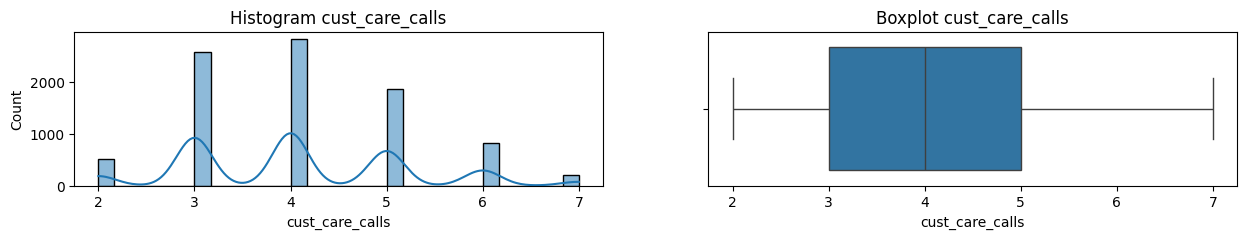

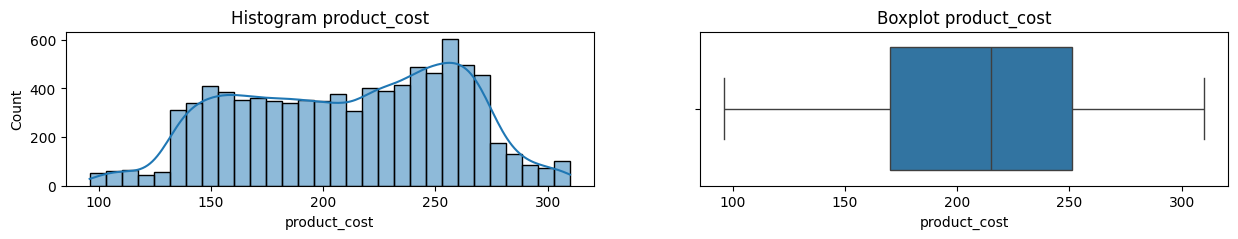

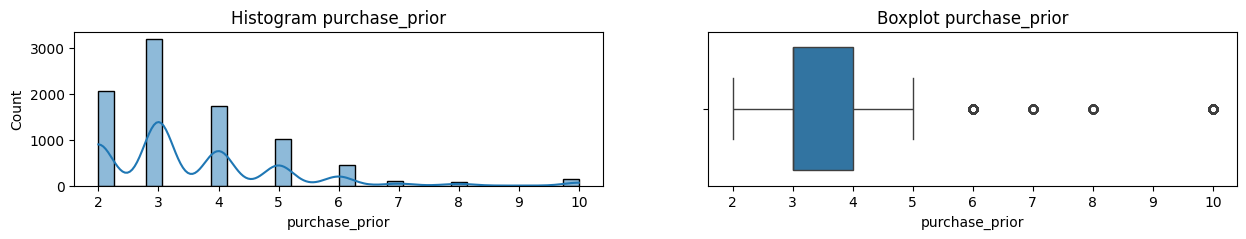

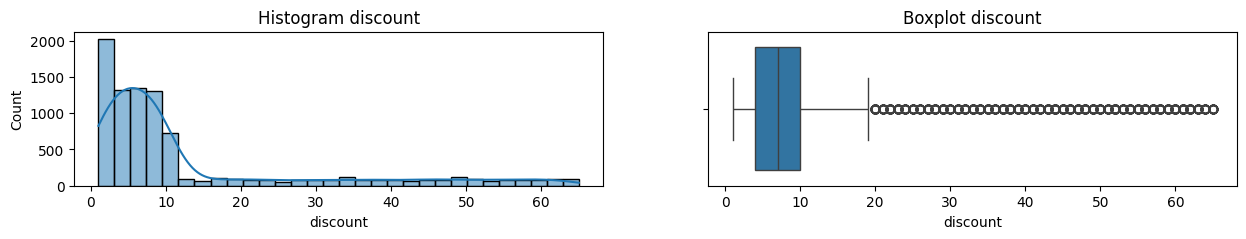

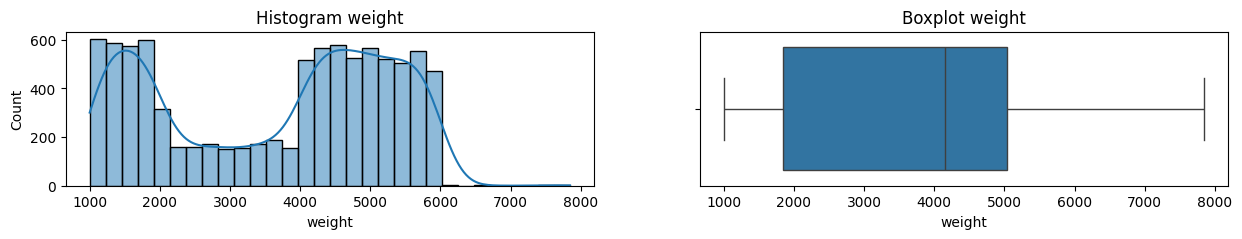

In [24]:
# Define plotting function
def make_plot(data, column):
    plt.figure(figsize = (15, 2))
    
    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[column], bins = 30, kde = True)
    plt.title(f"Histogram {column}")

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x = data[column])
    plt.title(f"Boxplot {column}")

    plt.show()

# Looping display plot
for col in num_col:
    make_plot(X_train, col)

Boundary outlier variabel `cust_care_calls`, `product_cost`, dan `weight` dihitung dengan metode Z, dan `purchase_prior` dan `discount` dihitung dengan Tukey's Rule.

In [25]:
# Define boundary function
def skew_boundary(data, column, fold):
    iqr = data[column].quantile(0.75) - data[column].quantile(0.25)
    low = data[column].quantile(0.25) - (fold * iqr)
    up = data[column].quantile(0.75) + (fold * iqr)
    return low, up

def normal_boundary(data, column):
    low = data[column].mean() - (3 * data[column].std())
    up = data[column].mean() + (3 * data[column].std())
    return low, up

In [26]:
# Make boundary to display % outlier
num_skew_col = []
num_norm_col = []
for col in num_col:
    if abs(X_train[col].skew()) <= 0.5:
        num_norm_col.append(col)
        low, up = normal_boundary(df, col)
    else:
        num_skew_col.append(col)
        low, up = skew_boundary(df, col, 3)

    print(f"Persentase outlier variabel {col}: {len(df[(df[col] < low) | (df[col] > up)])/len(df)*100:.2f}%")

Persentase outlier variabel cust_care_calls: 0.00%
Persentase outlier variabel product_cost: 0.00%
Persentase outlier variabel purchase_prior: 2.78%
Persentase outlier variabel discount: 16.32%
Persentase outlier variabel weight: 0.00%


Terlihat bahwa outlier ada di variabel `discount` dan `purchase_prior`. Namun, karena outlier kedua variabel ini nampak wajar (lebih banyak barang diskon sedikit dibanding diskon besar, dan lebih banyak orang yang tidak bertahan membeli hanya di satu toko dibandingkan berlangganan), maka outlier diasumsikan natural outlier sehingga tidak di-handling di program ini.

### Feature selection

Ditampilkan korelasis setiap variabel dengan target `delay`, dengan Phik correlation (karena dataset terdiri dari variabel numerik dan kategorikal).

In [27]:
# Phik correlation
train_set_fs = pd.concat([X_train, y_train], axis = 1)

train_types_fs = {
    # 'id':'int64',
    'warehouse_block':'categorical',
    'shipment_mode':'categorical',
    'cust_care_calls':'interval',
    'cust_rating':'ordinal',
    'product_cost':'interval',
    'purchase_prior':'interval',
    'product_importance':'ordinal',
    'gender':'categorical',
    'discount':'interval',
    'weight':'interval',
    'delay':'categorical',
}

interval_cols = [col for col, v in train_types_fs.items() if v == 'interval' and col in train_set_fs.columns]

phik_corr = train_set_fs.drop(["id"], axis = 1).phik_matrix(interval_cols = interval_cols)["delay"]
phik_corr

warehouse_block       0.000000
shipment_mode         0.000000
cust_care_calls       0.093293
cust_rating           0.000000
product_cost          0.091457
purchase_prior        0.150411
product_importance    0.013859
gender                0.000000
discount              0.577047
weight                0.497862
delay                 1.000000
Name: delay, dtype: float64

Dari korelasi di atas, dipilih fitur dengan korelasi > 0.1, sehingga model kita nantinya akan melibatkan:
- `purchase_prior`
- `discount`
- `weight`

In [28]:
# Select only used features
X_train_select = X_train[['purchase_prior', 'discount', 'weight']]
X_test_select = X_test[['purchase_prior', 'discount', 'weight']]

X_train_select.head()

,purchase_prior,discount,weight
887,3,21,1187
10164,4,4,4889
89,4,57,3880
3844,3,6,4323
3144,3,5,5335


### Feature scaling

Scaling dilakukan untuk memastikan tidak ada fitur yang mendominasi di model ML karena nilainya lebih besar dari yang lain. Untuk fitur yang terpilih di atas, akan diterapkan StandardScaler() untuk `weight` karena ia berdistribusi normal, dan RobustScaler() untuk `discount` dan `purchase_prior` karena memiliki outlier dan tidak mengasumsikan distribusi apapun.

Scaling dimasukkan sebagai bagian dari pipeline yang akan dijalankan saat modelling ML.

In [29]:
# Pipeline scaling
pipe_scaling = ColumnTransformer(
    transformers = [('pipe_num_norm', StandardScaler(), ['weight']),
                    ('pipe_num_skew', RobustScaler(), ['discount', 'purchase_prior'])],
    remainder = 'passthrough'
)

## Modelling

Dibuat pipeline untuk 5 model yang menjadi kandidat final model di program ini. 

In [30]:
# Pipeline modelling
pipe_knn = Pipeline([
    ('scaler', pipe_scaling), 
    ('clf', KNeighborsClassifier())
    ])
    
pipe_svc = Pipeline([
    ('scaler', pipe_scaling), 
    ('clf', SVC())
    ])
    
pipe_dt = Pipeline([
    ('scaler', pipe_scaling), 
    ('clf', DecisionTreeClassifier(random_state = 1))
    ])
    
pipe_rf = Pipeline([
    ('scaler', pipe_scaling), 
    ('clf', RandomForestClassifier(random_state = 1))
    ])
    
pipe_ada = Pipeline([
    ('scaler', pipe_scaling), 
    ('clf', AdaBoostClassifier(random_state = 1))
    ])

### Cross-validation

Pemilihan model terbaik akan menggunakan cross-validation, di mana metrics yang dipilih adalah Recall.

Perlu diingat kembali bahwa Recall digunakan karena ingin diminimalisir False Negative, atau kasus pengantaran yang terlambat namun terprediksi sebagai tepat waktu.

In [31]:
# Cross-validation
cv_knn = cross_val_score(pipe_knn, X_train_select, y_train, cv = StratifiedKFold(), scoring = 'recall')
cv_svc = cross_val_score(pipe_svc, X_train_select, y_train, cv = StratifiedKFold(), scoring = 'recall')
cv_dt = cross_val_score(pipe_dt, X_train_select, y_train, cv = StratifiedKFold(), scoring = 'recall')
cv_rf = cross_val_score(pipe_rf, X_train_select, y_train, cv = StratifiedKFold(), scoring = 'recall')
cv_ada = cross_val_score(pipe_ada, X_train_select, y_train, cv = StratifiedKFold(), scoring = 'recall')

# Best model
print('Cross Validation (All Baseline Models)\n')
print('KNN')
print(f'Recall score (all): {cv_knn}\nRecall score (mean): {cv_knn.mean():.2f}\nRecall score (sd): {cv_knn.std():.2f}\nRange recall score: {(cv_knn.mean() - cv_knn.std()):.2f} - {(cv_knn.mean() + cv_knn.std()):.2f}\n')
print('SVC')
print(f'Recall score (all): {cv_svc}\nRecall score (mean): {cv_svc.mean():.2f}\nRecall score (sd): {cv_svc.std():.2f}\nRange recall score: {(cv_svc.mean() - cv_svc.std()):.2f} - {(cv_svc.mean() + cv_svc.std()):.2f}\n')
print('Decision Tree')
print(f'Recall score (all): {cv_dt}\nRecall score (mean): {cv_dt.mean():.2f}\nRecall score (sd): {cv_dt.std():.2f}\nRange recall score: {(cv_dt.mean() - cv_dt.std()):.2f} - {(cv_dt.mean() + cv_dt.std()):.2f}\n')
print('Random Forest')
print(f'Recall score (all): {cv_rf}\nRecall score (mean): {cv_rf.mean():.2f}\nRecall score (sd): {cv_rf.std():.2f}\nRange recall score: {(cv_rf.mean() - cv_rf.std()):.2f} - {(cv_rf.mean() + cv_rf.std()):.2f}\n')
print('ADA Boosting')
print(f'Recall score (all): {cv_ada}\nRecall score (mean): {cv_ada.mean():.2f}\nRecall score (sd): {cv_ada.std():.2f}\nRange recall score: {(cv_ada.mean() - cv_ada.std()):.2f} - {(cv_ada.mean() + cv_ada.std()):.2f}\n')

Cross Validation (All Baseline Models)

KNN
Recall score (all): [0.66666667 0.68007663 0.6743295  0.67720307 0.64621285]
Recall score (mean): 0.67
Recall score (sd): 0.01
Range recall score: 0.66 - 0.68

SVC
Recall score (all): [0.51628352 0.49712644 0.48850575 0.49712644 0.48801534]
Recall score (mean): 0.50
Recall score (sd): 0.01
Range recall score: 0.49 - 0.51

Decision Tree
Recall score (all): [0.70114943 0.71551724 0.7059387  0.70881226 0.67305849]
Recall score (mean): 0.70
Recall score (sd): 0.01
Range recall score: 0.69 - 0.72

Random Forest
Recall score (all): [0.69157088 0.71168582 0.69731801 0.70785441 0.6759348 ]
Recall score (mean): 0.70
Recall score (sd): 0.01
Range recall score: 0.68 - 0.71

ADA Boosting
Recall score (all): [0.57758621 0.59099617 0.57088123 0.57854406 0.55417066]
Recall score (mean): 0.57
Recall score (sd): 0.01
Range recall score: 0.56 - 0.59



Dari hasil di atas, terlihat bahwa decision tree dan random forest memiliki rataan Recall score yang sama. Karena sifatnya yang mereduksi overfitting dan lebih robust terhadap outliers (_[referensi](https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/#:~:text=A%20decision%20tree%20is%20more,%2C%20healthcare%2C%20and%20deep%20learning.)_), dipilih Random Forest sebagai best model dan fitting model ke `X_train`. 

In [32]:
# Training
pipe_rf.fit(X_train_select, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipe_num_norm',
                                                  StandardScaler(),
                                                  ['weight']),
                                                 ('pipe_num_skew',
                                                  RobustScaler(),
                                                  ['discount',
                                                   'purchase_prior'])])),
                ('clf', RandomForestClassifier(random_state=1))])

Selanjutnya, di-prediksi target menggunakan `pipe_rf`. Perlu diingat kembali bahwa model ini masih model baseline, atau belum ada penyesuaian hyperparameter yang dilakukan.

In [33]:
# Predict
y_train_pred_rf = pipe_rf.predict(X_train_select)
y_test_pred_rf = pipe_rf.predict(X_test_select)

# Comparison report
report = pd.DataFrame({})
report['Random Forest (Baseline)'] = {
    'Train - Recall':recall_score(y_train, y_train_pred_rf),
    'Test - Recall':recall_score(y_test, y_test_pred_rf),
    }
report

,Random Forest (Baseline)
Train - Recall,0.988695
Test - Recall,0.698661


### Hyperparameter tuning

Diperoleh model yang overfit, dengan recall pada data test ~69.7%. Ingin dilakukan hyperparameter tuning dengan harapan mengurangi overfitting. Beberapa hal yang bisa dilakukan untuk mengurangi overfitting:
- Memperkecil max_depth
- Membesarkan min_sample_split
- Membesarkan min_sample_leaf
- Memperkecil max_leaf_nodes

Hyperparameter tuning akan dilakukan dengan metode Random Search dan juga Grid Search. Comparison report akan ditampilkan pada section ini untuk menyimpan nilai metric dari performa model.

In [34]:
# Display random forest tree parameters before tuning
pipe_rf['clf'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [35]:
# Random search
param_rf = {
    'clf__n_estimators':[100, 250, 400],
    'clf__max_depth':[15, 30, 45],
    'clf__min_samples_split':[3, 6, 9],
    'clf__min_samples_leaf':[2, 4, 6]
}
random = RandomizedSearchCV(pipe_rf, param_distributions = param_rf, cv = 5, n_iter = 50, random_state = 1, scoring = 'recall')
random.fit(X_train_select, y_train)
rf_random_best = random.best_estimator_
random.best_params_

{'clf__n_estimators': 400,
 'clf__min_samples_split': 3,
 'clf__min_samples_leaf': 2,
 'clf__max_depth': 45}

In [36]:
# Predict random search
y_train_pred_random = rf_random_best.predict(X_train_select)
y_test_pred_random = rf_random_best.predict(X_test_select)

# Comparison
report['Random Forest (Random Search)'] = {
    'Train - Recall':recall_score(y_train, y_train_pred_random),
    'Test - Recall':recall_score(y_test, y_test_pred_random),
    }
report

,Random Forest (Baseline),Random Forest (Random Search)
Train - Recall,0.988695,0.895574
Test - Recall,0.698661,0.691220


In [37]:
# Grid search
param_rf_2 = {
    'clf__n_estimators':[random.best_params_['clf__n_estimators'] - 75,
                         random.best_params_['clf__n_estimators'] - 50,
                         random.best_params_['clf__n_estimators']],
    'clf__max_depth':[random.best_params_['clf__max_depth'] - 7,
                      random.best_params_['clf__max_depth'] - 4,
                      random.best_params_['clf__max_depth']],
    'clf__min_samples_split':[random.best_params_['clf__min_samples_split'],
                              random.best_params_['clf__min_samples_split'] + 1,
                              random.best_params_['clf__min_samples_split'] + 3],
    'clf__min_samples_leaf': [random.best_params_['clf__min_samples_leaf'],
                              random.best_params_['clf__min_samples_leaf'] + 1,
                              random.best_params_['clf__min_samples_leaf'] + 2]
}
grid = GridSearchCV(pipe_rf, param_grid = param_rf_2, cv = 5, scoring = 'recall')
grid.fit(X_train_select, y_train)
rf_grid_best = grid.best_estimator_
grid.best_params_

{'clf__max_depth': 38,
 'clf__min_samples_leaf': 2,
 'clf__min_samples_split': 3,
 'clf__n_estimators': 350}

In [38]:
# Predict grid search
y_train_pred_grid = rf_grid_best.predict(X_train_select)
y_test_pred_grid = rf_grid_best.predict(X_test_select)

# Comparison
report['Random Forest (Grid Search)'] = {
    'Train - Recall':recall_score(y_train, y_train_pred_grid),
    'Test - Recall':recall_score(y_test, y_test_pred_grid),
    }
report


,Random Forest (Baseline),Random Forest (Random Search),Random Forest (Grid Search)
Train - Recall,0.988695,0.895574,0.895765
Test - Recall,0.698661,0.691220,0.688244


### Evaluation

Performa model akan dianalisa dari classification report dan confusion matrix untuk 3 model Random Forest: Baseline, Tuning Random Search, dan Tuning Grid Search.

Perlu diingat kembali bahwa metric yang dipilih untuk evaluasi model adalah Recall. Untuk refresh, target adalah variabel `delay` dengan:
- 0: order sampai on-time
- 1: order sampai delay

Fokus kita adalah untuk order yang delay, agar bisa dibantu untuk percepatan penyelesaian masalah selama pengantaran. Oleh karena itu, ingin diminimalisir False Negative, atau prediksi bahwa order on-time padahal sebenarnya delay. 

Ingin dilihat kembali comparison report yang sudah dibuat saat model training dan hyperparameter tuning.


In [39]:
# Comparison report
report

,Random Forest (Baseline),Random Forest (Random Search),Random Forest (Grid Search)
Train - Recall,0.988695,0.895574,0.895765
Test - Recall,0.698661,0.691220,0.688244


Terlihat bahwa model yang terbaik adalah Random Forest hasil dari tuning Random Search. Hal yang dipertimbangkan adalah nilai recall dari data test yang masih baik, serta nilai recall dari data train yang menurun untuk mengurangi overfitting.

Lebih detilnya akan dilihat dengan classification report dan confusion matrix di bawah.

#### 1. Baseline model

Random Forest (Baseline)

Recall score:  0.6986607142857143 

Classification report: 
               precision    recall  f1-score   support

           0       0.56      0.59      0.57       856
           1       0.73      0.70      0.71      1344

    accuracy                           0.66      2200
   macro avg       0.64      0.65      0.64      2200
weighted avg       0.66      0.66      0.66      2200
 

Confusion matrix: 


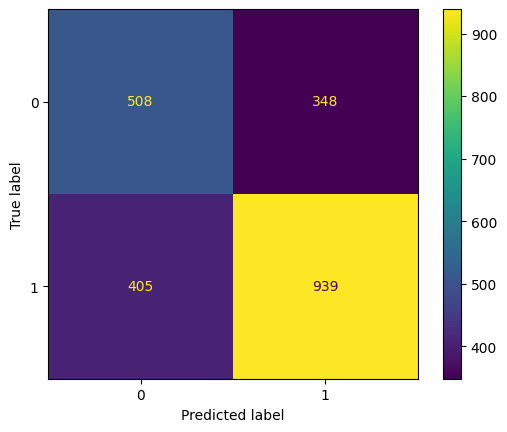

In [40]:
# Classification report & confusion matrix
print('Random Forest (Baseline)\n')
print('Recall score: ', recall_score(y_test, y_test_pred_rf), '\n')
print('Classification report: \n', classification_report(y_test, y_test_pred_rf), '\n')
print('Confusion matrix: \n', ConfusionMatrixDisplay.from_estimator(pipe_rf, X_test_select, y_test))

Nilai recall sekitar 69.9%, dengan False Negative ada sebanyak 405 observasi. Maka untuk hyperparameter tuning, ditargetkan agar angka ini turun.

#### 2. Random search

Random Forest (Random Search)

Recall score:  0.6912202380952381 

Classification report: 
               precision    recall  f1-score   support

           0       0.57      0.64      0.60       856
           1       0.75      0.69      0.72      1344

    accuracy                           0.67      2200
   macro avg       0.66      0.66      0.66      2200
weighted avg       0.68      0.67      0.67      2200
 



Confusion matrix: 


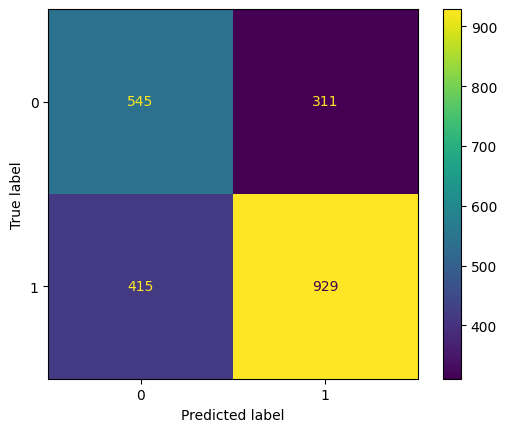

In [41]:
# Classification report & confusion matrix
print('Random Forest (Random Search)\n')
print('Recall score: ', recall_score(y_test, y_test_pred_random), '\n')
print('Classification report: \n', classification_report(y_test, y_test_pred_random), '\n')
print('Confusion matrix: \n', ConfusionMatrixDisplay.from_estimator(rf_random_best, X_test_select, y_test))

Nilai recall menurun menjadi 69.1%, dan angka False Negative naik 10 menjadi 415. Tapi perlu diperhatikan juga bahwa nilai True Positive meningkat dari 508 menjadi 545, yang menjadi nilai plus untuk model hasil tuning.

#### 3. Grid search

Random Forest (Grid Search)

Recall score:  0.6882440476190477 

Classification report: 
               precision    recall  f1-score   support

           0       0.57      0.64      0.60       856
           1       0.75      0.69      0.72      1344

    accuracy                           0.67      2200
   macro avg       0.66      0.66      0.66      2200
weighted avg       0.68      0.67      0.67      2200
 

Confusion matrix: 


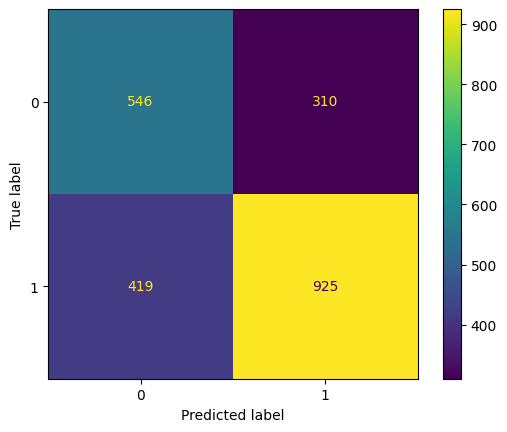

In [42]:
# Classification report & confusion matrix
print('Random Forest (Grid Search)\n')
print('Recall score: ', recall_score(y_test, y_test_pred_grid), '\n')
print('Classification report: \n', classification_report(y_test, y_test_pred_grid), '\n')
print('Confusion matrix: \n', ConfusionMatrixDisplay.from_estimator(rf_grid_best, X_test_select, y_test))

Nilai recall menurun lagi dari model menjadi 68.8%, dan angka False Negative naik 4 menjadi 419. Ada kenaikan juga di True Positive sebanyak 1, tidak signifikan jika dibandingkan dengan perbaikan pada Random Search.

Dengan melihat 3 classification report dan confusion matrix, disimpulkan bahwa model terbaik adalah **Random Forest yang dihasilkan dari tuning Random Search**, dengan mempertimbangkan nilai Recall train set (tidak overfitting separah baseline model), Recall test set (paling baik di antara model hasil tuning), dan perbaikan False Negative dan True Positive yang lebih signifikan.

### Analysis 

Beberapa hal menarik dari proses model definition sampai evaluation:
1. **Cross-validation**  
Proses ini membuat validations set yang membuat kita bisa menganalisa dengan metric terpilih (Recall), model manakah yang paling baik sebelum mengujinya dengan data test. Dari rata-rata Recall, dihasilkan model Decision Tree dan Random Forest adalah yang paling baik.
Model Random Forest dipilih karena kemampuannya untuk mereduksi overfitting, dan ketahanannya terhadap outliers. 
Di sisi lain, model lainnya punya nilai recall beragam. Performa KNN cukup baik, diikuti dengan AdaBoost dan SVC dengan recall < 60%.

2. **Baseline model: Random Forest**  
Performa baseline model untuk data train sangat baik, mendekati 100%. Namun saat diuji dengan data test, ada drop ke nilai recall ~70%. Ini menandakan overfitting data train, yang kerapkali memang ditemui di model Decision Tree dan Random Forest (bagging Decision Tree). 

3. **Hyperparameter tuning**  
Dilakukan Random Search sebagai metode tuning pertama, dan Grid Search untuk tuning kedua kalinya. Digunakan 2 metode tuning untuk mendapatkan hyperparameter yang benar-benar bisa mengoptimalkan model (mengingat performa model kurang baik) dan menurunkan overfitting. Diperoleh model dengan nilai Recall paling baik dari Random Search, yaitu: **Random Forest (n_estimators = 400, max_depth = 45, min_samples_split = 3, min_samples_leaf = 2)**. Terlihat model masih overfitting, namun tidak separah baseline model. Nilai recall turun sedikit sekali, tidak signifikan. Setidaknya kita berhasil untuk membuat model berkurang taraf overfit-nya.

4. **Imbalance dataset**  
Kategori minoritas di target porsinya hampir 40%. Ini menandakan mild imbalance data. Bisa saja performa model juga terpengaruh oleh ini, karena data "kurang training" untuk kategori minoritas. Untuk ke depannya lebih baik dicoba menerapkan metode handling imbalance data, seperti SMOTE, undersampling, oversampling, dll.

### Saving 

Model terbaik, yaitu `rf_random_best`, akan disimpan menjadi file lain agar bisa digunakan saat inferencing dan deployment.

In [43]:
# Saving
with open('model.pkl', 'wb') as file_1: 
  pickle.dump(rf_random_best, file_1)

### Inference

Model inference dilakukan pada notebook terpisah, yaitu `P1M2_wilona_inf.ipynb`.

## Conclusion

### Conceptual problems

1. **Jelaskan latar belakang adanya bagging dan cara kerja bagging!**  
Bagging adalah salah satu metode ensemble learning, di mana metode ini mengombinasikan beberapa model untuk membentuk model yang meningkatkan performa dan akurasi. Untuk bagging (bootstrap aggregating), pengombinasian model adalah dengan membagi terlebih dahulu data menjadi sejumah subset data (bootstrap), lalu training beberapa model dalam 1 waktu bersamaan terhadap subset data yang berbeda-beda. Kemudian, masing-masing model akan melakukan prediksi dan dicari rata-rata (regresi) atau dengan voting (klasifikasi). 

2. **Jelaskan perbedaan cara kerja algoritma Random Forest dengan algoritma boosting yang Anda pilih!**  
Random Forest merupakan alah satu contoh paling diketahui dari bagging. Model ini didasari oleh Decision Tree (dapat dibayangkan kumpulan pohon yang membentuk hutan). Cara kerjanya adalah dengan melatih sejumlah Decision Tree terhadap subset data yang berbeda, dan mengagregatkan hasil prediksinya dengan merata-ratakan atau voting.  
Sementara itu, metode boosting dilakukan secara berurutan dengan tujuan untuk memperbaiki model yang sudah dilatih di urutan sebelumnya. Kesalahan model diberikan bobot di setiap iterasi model baru,sehingga model bisa "fokus" pada data error tersebut. Di program ini, dipakai metode boosting AdaBoost, yang pendekatannya adalah dengan fokus pada sampel yang salah diklasifikasikan oleh model.

3. **Jelaskan apa yang dimaksud dengan Cross Validation!**  
Cross validation adalah teknik yang dilakukan untuk mengukur performa model dengan cara membentuk subset data (validation set). Validation set akan dibuat dari train set, dan model akan di-fit dengan train set (tanpa validation set), kemudian performanya diukur menggunakan pengujian validation set. Proses ini dilakukan berulang sesuai berapa kali yang sudah ditentukan. Lalu performa diambil dari rata-rat nilai metric yang dihasilkan setiap model. Ini metode yang bagus untuk memilih model terbaik dari beberapa kandidat yang ada.

### Overall analysis

Berikut ringkasan dari apa saja yang dilakukan dalam program ini:
1. Data diambil dari Kaggle terkait shipping sebuah perusahaan elektronik, yang disimpan menjadi `product_shipment.csv`
2. Load data ke dalam dataframe `df` untuk eksplorasi dan pre-processing
3. Import library yang dibutuhkan untuk dapat menjalankan keseluruhan program, yang mencakup pre-processing, feature engineering, pipeline, dan modelling (termasuk evaluation dan saving)
4. Eksplorasi data (EDA) untuk memahami data secara keseluruhan (variabel yang terlibat pada dataset, hubungan antar variabel, dan visualisasi, dll)
5. Feature Engineering (FE) dilakukan dengan menentukan data inferens, train dan test, kemudian pre-processing data dan memilih fitur dan target yang dilibatkan dalam model. Scaling dilakukan dengan menggunakan pipeline yang akan dijalankan bersamaan dengan modelling. Fitur yang dipakai untuk modelling adalah `purchase_prior`, `weight`, dan `discount`
6. Modelling, dengan kandidat 5 baseline model, lalu memilih model terbaik dengan membandingkan Recall dari cross-validation (karena ingin meminimalisir False Negative), lalu mengoptimalkan dengan hyperparameter tuning (Random Search dan Grid Search). Dari proses ini, didapatkan model terbaik dari Random Search, yaitu Random Forest (n_estimators = 400, max_depth = 45, min_samples_split = 3, min_samples_leaf = 2) dengan Recall 69.1%
7. Prediksi dengan data inferens yang sudah dipisahkan sebelum FE

Secara keseluruhan, program berjalan dengan baik tanpa adanya error.

Hal menarik yang dapat diambil dari EDA:
- Lebih banyak pesanan yang sampai terlambat daripada yang datang on-time
- Telepon yang diterima oleh customer care rata-rata sebanyak 4x per transaksi, namun kemungkinan besar tidak terkait dengan isu keterlambatan pesanan. Melihat jumlah call yang semakin banyak seiring naiknya harga produk, bisa jadi customer menelepon untuk informasi yang diperlukan seperti penggunaan barang atau jasa maintenance
- Perusahaan menjual barang elektronik dengan rentang harga yang tidak terlalu lebar dan harga yang dipatok lumayan tinggi, dan dapat disimpulkan mungkin perusahaan hanya menjual line produk tertentu 
- Rata-rata pembeli melakukan pembelian berulang, atau menjadi langganan
- Diskon yang diberikan tidak banyak, mengindikasikan mungkin perusahaan menjaga pricing produknya stay di rentang tertentu. Akan tetapi ditemukan pola di mana pelanggan yang berbelanja <= 3x dan >= 7x mendapat diskon lebih banyak (walaupun tidak signifikan). Bisa jadi ada program diskon khusus seperti new membership atau loyal member
- Barang yang terlambat sampai rata-rata didiskon > 20%. Dengan tren saat ini di mana ada hari-hari tertentu untuk para penjual mengadakan diskon besar-besaran secara bersamaan, bisa terjadi pesanan yang membludak dan jasa pengantaran pun overwhelmed dengan volume produk, dan berdampak pada pengantaran yang behind schedule
- Pengiriman paling banyak dilakukan dengan kapal, dan produk-produk yang lebih berat akan diantar dengan moda ini. Produk yang paling berat berkisar di angka 8 kg, dan umumnya arang eletronik seberat ini adalah perabotan rumah tangga. Terlihat dari EDA bahwa pesanan yang delayed cenderung lebih berat
- Ada 5 warehouse block, di mana pengiriman terbanyak dilakukan dari warehouse F. Perbedaan warehouse (lokasi) tidak berpengaruh pada apakah pesanan akan sampai tepat waktu atau tidak
- Ada pengkategorian produk yang dibuat perusahaan: low, medium, high. Tidak ada informasi terkait ini, dan tidak berdampak juga pada seberapa cepat pesanan sampai ke tujuan (sepertinya bukan diprioritaskan untuk on-time)
- Rating yang diberikan customer sangat merata, untuk setiap angka di skala 1.0 sampai 5.0. Ini juga tidak berkaitan dengan apakah pesanan delayed atau on-time, karena tidak ada perbedaan porsi rating yang signifikan antara keduanya

Highlight dari proses modelling:
- Pipeline memudahkan dan menyederhanakan proses modelling secara signifikan
- Cross validation atas 5 model mengeluarkan nilai Recall yang beragam, dan didapati Random Forest & Decision Tree punya rataan Recall yang sama, yaitu 70%
- Dipilih Random Forest sebagai baseline model karena kelebihannya untuk menghandle overfitting dan robust terhadap outliers, walaupun komputasi yang dilakukan memakan waktu lebih banyak dan costly secara resources
- Recall untuk data train pada baseline model sangat overfit, berkisar di 98%
- Hyperparameter tuning bertujuan untuk menurunkan taraf overfitting model dan meningkatkan performa. Ada perbaikan walaupun masih overfit, dengan Recall data train di 89% dan data test di 69%
- Recall dari model yang sudah di-tuning memang belum baik, atau bisa dikatakan tidak good-fit


Saran untuk improvement model ke depannya:
- Handling imbalance dataset (walaupun data ini mildly imbalance saja), bisa dengan SMOTE atau metode lainnya seperti undersampling, oversampling, dll
- Mencari metode khusus untuk handling natural outlier, seperti transformasi data (dengan fungsi log atau sqrt)
- Mencoba menggunakan model yang lebih sederhana/tidak kompleks, untuk menghemat waktu dan komputasi  
- Menggunakan model ensemble learning lainnya untuk modelling demi meningkatkan performa dan akurasi model, seperti boosting atau stacking
- Tetap menggunakan cross validation dan hyperparameter tuning, karena efektif dalam pemilihan best model serta pengoptimalan model

> Kesimpulan akhir, untuk menyelesaikan masalah keterlambatan pesanan, perusahaan bisa mencoba beberapa cara:
- Manage inventory dan menyusun SOP pengiriman barang yang lebih berat dengan lebih efektif, misalkan menghandle pengiriman secara langsung dari perusahaan ke customer (tidak memakai jasa pengantaran atau memiliki bisnis pengantaran sendiri)
- Memberikan rentang waktu yang reasonable untuk hari-hari yang diprediksi akan ramai pesanan, seperti hari raya atau double date (11.11, 12.12, dll) agar pelanggan mengerti dan bisa mengatur ekspektasi kapan barang akan sampai. Di saat yang sama, perusahaan bisa mencari jasa pengantaran yang sudah punya SOP tertentu untuk menghadapi pesanan membludak, atau bahkan membuat bisnis pengantaran sendiri